## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import optuna
import numpy as np

In [34]:
df = pd.read_excel('dataset.xlsx', sheet_name='Sheet1') 
data = df.iloc[:,:-1]

## Preprocessing

In [35]:
scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(data.copy())
df_scaled = pd.DataFrame(df_scaled, columns=data.columns)

df_scaled.head(1)

,meanR,meanG,meanB,stdR,stdG,stdB,skewR,skewG,skewB,kurR,kurG,kurB,entR,entG,entB
0,0.262619,0.37327,0.223369,0.309574,0.497217,0.345519,0.381338,0.327242,0.373931,0.246299,0.188223,0.202234,0.586973,0.589226,0.392681


In [36]:
X_train = df_scaled
y_train = df['Class']

## Dimension Reduction

In [38]:
tsne = TSNE(n_components=2, perplexity=21, n_iter=1269, random_state=42, learning_rate = 18.896459784706366)
X_tsne = tsne.fit_transform(X_train)

d:\Kuliah\JST\Neural-Network-Final-Project\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


###Building Model

In [40]:
class SOMlinier:
    def __init__(self, m, fitur, R, alpha, tau):
        self.m = m 
        self.fitur = fitur 
        self.w = np.random.rand(m, fitur) 
        self.R0 = R 
        self.alpha0 = alpha
        self.tau = tau
    
    def hitung_bmu(self, x):
        D = np.linalg.norm(self.w - x, axis=1)
        return np.argmin(D)
    
    def hitung_second_bmu(self, x):
        D = np.linalg.norm(self.w - x, axis=1)
        return np.argsort(D)[1]
    
    def update_bobot(self, x, j, R, alpha):
        for i in range(self.m):
            jarak = abs(i - j)
            if jarak <= R:
                influence = np.exp(-jarak**2 / (2 * (R**2)))
                self.w[i] += alpha * influence * (x - self.w[i])
    
    def kurangi_radius(self, iterasi):
        return self.R0 * np.exp(-iterasi / self.tau)

    def kurangi_learning_rate(self, iterasi):
        return self.alpha0 * np.exp(-iterasi / self.tau)

    def train(self, data, n_iterasi):
        for t in range(n_iterasi):
            x = data[np.random.randint(0, len(data))]
            j = self.hitung_bmu(x)
            R = self.kurangi_radius(t)
            alpha = self.kurangi_learning_rate(t)
            self.update_bobot(x, j, R, alpha)

    def quantization_error(self, data):
        total_error = np.mean([np.linalg.norm(x - self.w[self.hitung_bmu(x)]) for x in data])
        return total_error
    
    def topographic_error(self, data):
        errors = 0
        for x in data:
            bmu = self.hitung_bmu(x)
            second_bmu = self.hitung_second_bmu(x)
            if abs(bmu - second_bmu) > 1:
                errors += 1
        te = errors / len(data)
        return te

In [41]:
m = 6      
fitur = 2
R = 4  
alpha0 = 0.1      
tau = 600             
n_iterations = 1000


som_tsne = SOMlinier(m=m, fitur=fitur, R=R, alpha=alpha0, tau=tau)

som_tsne.train(X_tsne, n_iterations)

weights_tsne = som_tsne.w
print("Trained SOM weights:", weights_tsne)

Trained SOM weights: [[ 41.42799185  -3.85627074]
 [ 25.51143118  13.58182966]
 [  1.32282923  27.37736865]
 [ -9.77119566   6.95833344]
 [-13.56223172 -18.88683273]
 [-35.99719378 -10.4934457 ]]


In [42]:
def plot_cluster(data, som, weights):
    bmu_indices_pca = [som.hitung_bmu(x) for x in data]

    plt.figure(figsize=(12, 6))

    unique_bmu_indices_pca = np.unique(bmu_indices_pca)
    colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices_pca))  

    for i, bmu in enumerate(unique_bmu_indices_pca):
        cluster_data_pca = data[np.array(bmu_indices_pca) == bmu]
        plt.scatter(cluster_data_pca[:, 0], cluster_data_pca[:, 1], label=f'Cluster {bmu}', color=colors(i), alpha=0.5)

    plt.plot(weights[:, 0], weights[:, 1], 'r-o', label="Neuron (Linear Topology)", markersize=8)

    plt.title("Distribusi Data berdasarkan BMU (PCA)")
    plt.xlabel("Fitur 1 (PCA)")
    plt.ylabel("Fitur 2 (PCA)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


C:\Users\lmaos\AppData\Local\Temp\ipykernel_6696\166035939.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices_pca))


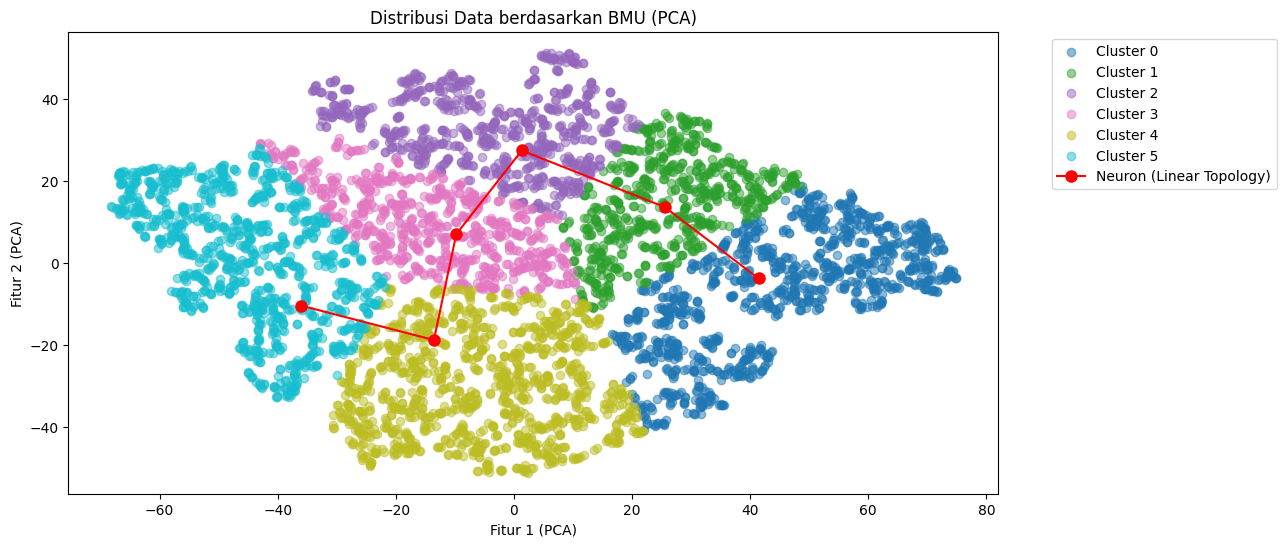

In [43]:
plot_cluster(X_tsne,som_tsne, weights_tsne)

### Evaluasi Sebelum Tuning

In [45]:
def qete(som, data):
    qe = som.quantization_error(data)
    te = som.topographic_error(data)

    return print("Quantization Error (QE):", qe, "\nTopographic Error (TE)", te)

In [46]:
qete(som_tsne, X_tsne)

Quantization Error (QE): 17.97288135886196 
Topographic Error (TE) 0.21463932107496464


In [47]:
def silhouette(som, data):
    bmu_indices = [som.hitung_bmu(x) for x in data]

    cluster_labels = np.array(bmu_indices)

    silhouette_avg = silhouette_score(data, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")

In [49]:
silhouette(som_tsne, X_tsne)

Silhouette Score: 0.3238


### Evaluasi Setelah Tuning

In [52]:
X_train_optuna = X_tsne

m = 6
fitur = X_train_optuna.shape[1]  
R = 1.5499971728390252
alpha0 = 0.316498554782185
tau = 604
n_iterations = 1188

som_optuna = SOMlinier(m=m, fitur=fitur, R=R, alpha=alpha0, tau=tau)

som_optuna.train(X_train_optuna, n_iterations)

weights_optuna = som_optuna.w
print("Trained SOM weights:", weights_optuna)

Trained SOM weights: [[-22.2878179  -18.93277152]
 [-45.40704089  11.03939911]
 [ -5.23277483  28.62373901]
 [ 21.10177267  16.9110582 ]
 [ 48.67553674  -1.24433139]
 [ 12.44678305 -29.50247865]]


C:\Users\lmaos\AppData\Local\Temp\ipykernel_6696\166035939.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices_pca))


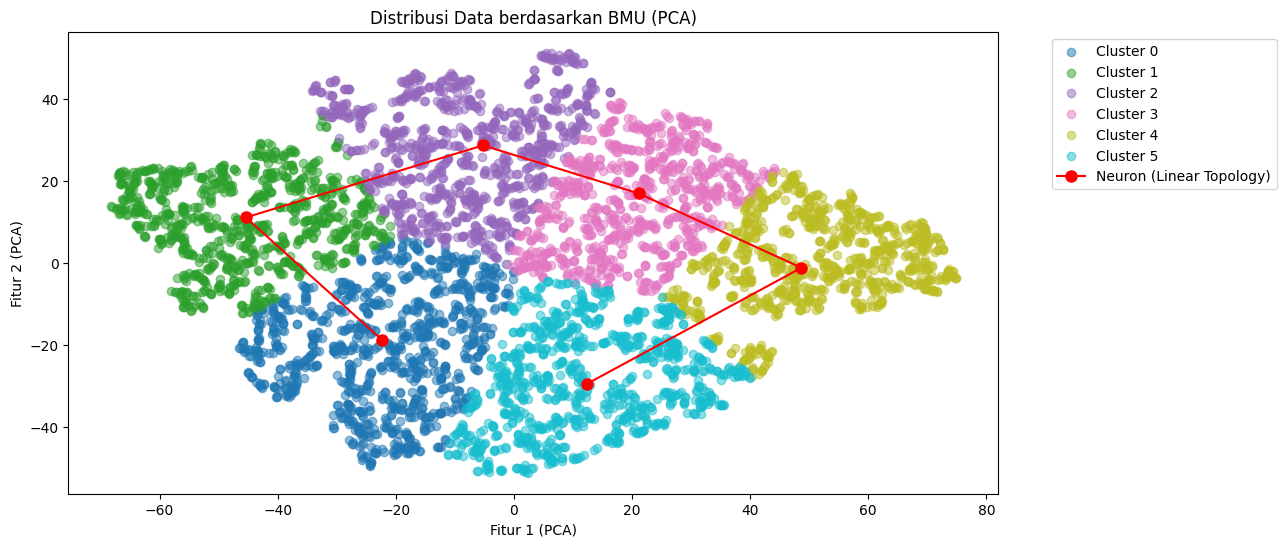

In [53]:
plot_cluster(X_train_optuna, som_optuna, weights_optuna)

In [54]:
qete(som_optuna, X_train_optuna)

Quantization Error (QE): 15.325053482300312 
Topographic Error (TE) 0.26414427157001413


In [55]:
silhouette(som_optuna, X_train_optuna)

Silhouette Score: 0.3665


### Analisis Lebih Lanjut

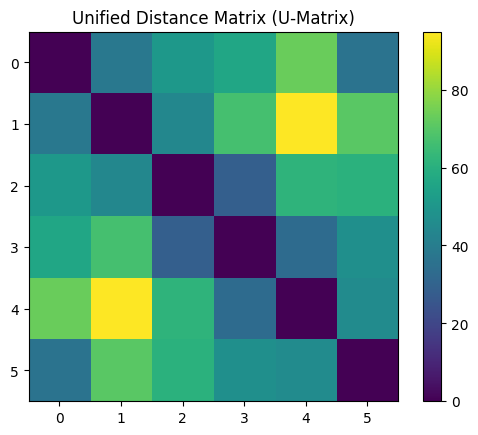

In [56]:
from scipy.spatial.distance import cdist

u_matrix = cdist(weights_optuna, weights_optuna)
plt.imshow(u_matrix, cmap='viridis')
plt.title("Unified Distance Matrix (U-Matrix)")
plt.colorbar()
plt.show()


In [68]:
def profil_kluster(som, data):
    kluster = [som.hitung_bmu(x) for x in data]
    df = pd.DataFrame(data)
    df['kluster'] = kluster
    
    profil = df.groupby('kluster').agg(['mean', 'std', 'min', 'max'])
    return profil

profil_kluster_result = profil_kluster(som_optuna, X_train_optuna)
print("Profil Kluster:\n", profil_kluster_result)

Profil Kluster:
                  0                                           1             \
              mean        std        min        max       mean        std   
kluster                                                                     
0       -21.964689  11.211451 -46.528381   0.073501 -20.222342  13.501199   
1       -45.757305  11.848074 -68.290909 -20.914503  10.291271  10.114516   
2        -8.173436  11.532064 -34.201767  16.301315  27.594725  12.422937   
3        20.765728  10.066974  -0.960371  44.185154  14.997086  11.456554   
4        51.310581  12.004863  25.174572  74.872452   0.223910  10.054017   
5        12.105907  12.075752 -11.187179  39.937717 -28.766951  11.709123   

                               
               min        max  
kluster                        
0       -49.500755   5.975071  
1       -12.327888  36.038719  
2         1.163354  51.236008  
3        -7.008135  39.113049  
4       -27.732592  22.042135  
5       -51.263138  -4.452302  


In [70]:
from scipy import stats

def identifikasi_fitur_penting(som, data):
    kluster = [som.hitung_bmu(x) for x in data]
    df = pd.DataFrame(data)
    df['kluster'] = kluster
    
    fitur_penting = {}
    
    for i in range(data.shape[1]): 
        grup = [df[df['kluster'] == k].iloc[:, i] for k in range(som.m)]
        
        f_stat, p_value = stats.f_oneway(*grup)
        
        fitur_penting[f'Fitur {i}'] = {'F-statistic': f_stat, 'p-value': p_value}
    
    return fitur_penting

X_train_optuna = X_tsne   
fitur_penting_result = identifikasi_fitur_penting(som_optuna, X_train_optuna)

for fitur, hasil in fitur_penting_result.items():
    print(f"{fitur}: F-statistic = {hasil['F-statistic']:.4f}, p-value = {hasil['p-value']:.4f}")

Fitur 0: F-statistic = 8070.5874, p-value = 0.0000
Fitur 1: F-statistic = 3316.4084, p-value = 0.0000


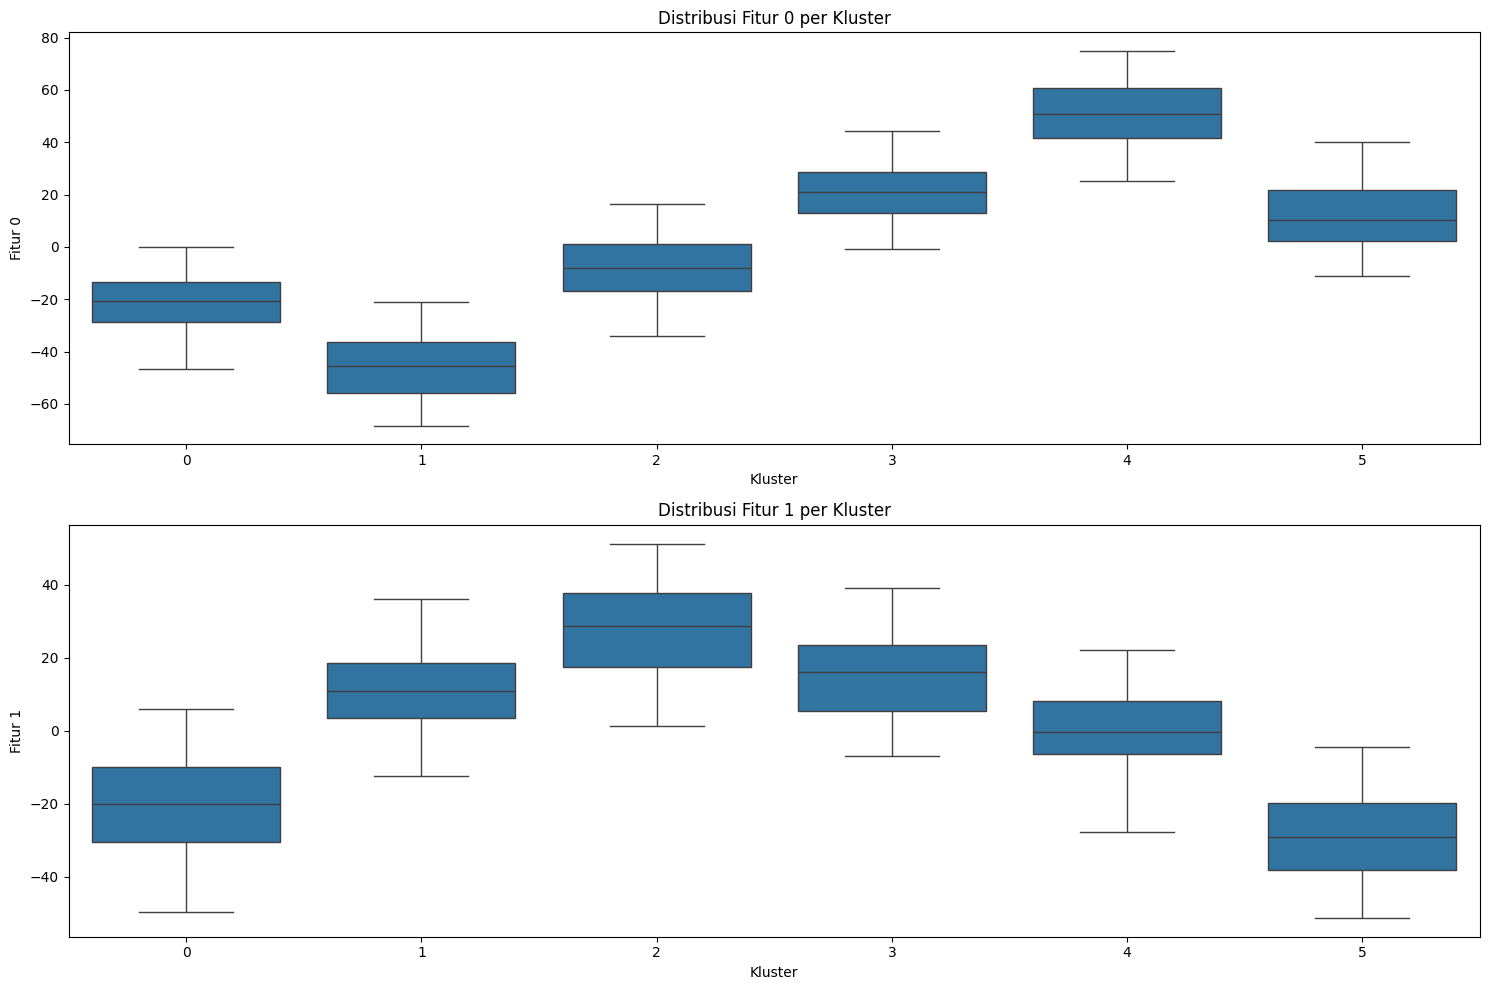

In [72]:
import seaborn as sns

def visualisasi_distribusi_fitur(som, data):
    kluster = [som.hitung_bmu(x) for x in data]
    df = pd.DataFrame(data)
    df['kluster'] = kluster
    
    plt.figure(figsize=(15, 10))
    
    for i in range(data.shape[1]):
        plt.subplot(2, (data.shape[1] + 1) // 2, i + 1)  
        sns.boxplot(x='kluster', y=df.columns[i], data=df)
        plt.title(f'Distribusi Fitur {i} per Kluster')
        plt.xlabel('Kluster')
        plt.ylabel(f'Fitur {i}')
    
    plt.tight_layout()
    plt.show()

visualisasi_distribusi_fitur(som_optuna, X_train_optuna)

## Tuning

In [51]:
def objective(trial):
    m = trial.suggest_int('m', 2, 6) 
    R = trial.suggest_float('R', 0.1, 5.0)
    alpha0 = trial.suggest_float('alpha0', 0.01, 0.5) 
    tau = trial.suggest_int('tau', 100, 2000) 
    n_iterations = trial.suggest_int("n_iterations", 500, 1500)

    som_pca = SOMlinier(m=m, fitur=2, R=R, alpha=alpha0, tau=tau)
    som_pca.train(X_tsne, n_iterations)

    qe = som_pca.quantization_error(X_tsne)
    te = som_pca.topographic_error(X_tsne)

    return qe + te

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best Parameters (Optuna):", study.best_params)
print("Best Score (QE + TE):", study.best_value)

[I 2024-11-20 20:32:18,076] A new study created in memory with name: no-name-50c06569-6f58-4fe2-a22c-23dabed5f371
[I 2024-11-20 20:32:18,182] Trial 0 finished with value: 23.376570947423524 and parameters: {'m': 5, 'R': 3.380039509280665, 'alpha0': 0.04993907500722654, 'tau': 628, 'n_iterations': 502}. Best is trial 0 with value: 23.376570947423524.
[I 2024-11-20 20:32:18,285] Trial 1 finished with value: 23.97874318672619 and parameters: {'m': 3, 'R': 1.2305600424092693, 'alpha0': 0.3719183844171212, 'tau': 368, 'n_iterations': 794}. Best is trial 0 with value: 23.376570947423524.
[I 2024-11-20 20:32:18,400] Trial 2 finished with value: 29.78452967299045 and parameters: {'m': 3, 'R': 3.9590707691885165, 'alpha0': 0.021656335713629515, 'tau': 1321, 'n_iterations': 989}. Best is trial 0 with value: 23.376570947423524.
[I 2024-11-20 20:32:18,523] Trial 3 finished with value: 18.195628475225863 and parameters: {'m': 6, 'R': 2.6253046536251805, 'alpha0': 0.22469208195650212, 'tau': 1666, '

Best Parameters (Optuna): {'m': 6, 'R': 1.5499971728390252, 'alpha0': 0.316498554782185, 'tau': 604, 'n_iterations': 1188}
Best Score (QE + TE): 15.317088969066452
